<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Authors: [Pavel Nesterov](http://pavelnesterov.info/) (@mephistopheies), [Yury Kashnitskiy](https://yorko.github.io) (@yorko), and [Daniel Potapov](https://www.linkedin.com/in/daniel-potapov/) (@sharthZ23). Edited by [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/) (@manokhina). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #8. Fall 2018
## <center> StackOverflow questions tagging with logistic regression

**Fill in the code in the cells and select answers in the [web form](https://docs.google.com/forms/d/1FsawLzl_i3nw-ahECsJAJkd0SxFsmWDS5sS2hr6RbKY).**

## 0. Problem description

In this assignment, we will code a model for predicting tags based on a multilabel logistic regression. Unlike the usual setting of a multiclass problem, in this case one example can belong to several classes. We will implement an online version of the multilabel classification algorithm.

We will use a small sample of 70k questions extracted from StackOverflow (about 23 MB if zipped, download from [here](https://drive.google.com/file/d/1djuygR3cTXb4go_KMWSOw94WlFKb2NT5/view?usp=sharing)).

Actually, such implementations are used in real life (though not implemented in Python). For example, in online [Click-Through Rate](https://en.wikipedia.org/wiki/Click-through_rate) prediction models, the user is shown a banner, then, depending on the presence of a click, the model parameters are updated. In real applications, the amount of model parameters of can reach hundreds of millions, while one user usually has only a hundred or a thousand non-zero parameters out of this hundred millions, therefore it is not effective to vectorize such a model. Usually all user data is stored in huge clusters in in-memory databases, and user processing is distributed.

> Data Science is the math for your business 

To perfectly grasp this folk wisdom, we'll dive into the math of multiclass & multilabel logistic regression.

## 1. Multiclass & multilabel logistic regression

### 1.1. Softmax classifier (multiclass logistic regression)

Let's see how logistic regression is derived for two classes $ \left\{0, 1\right\}$: the probability that an instance belongs to class $1$ is derived from the Bayes theorem:

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x}\right)} \\
&=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} = \sigma\left(a\right)
\end{array}$$
where:
- $\vec{x}$ – is a feature vector
- $\sigma$ – stands for the sigmoid function of a scalar argument
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^{d} w_i x_i$ – this relation is modeled by a linear function of features and model parameters

This expression can easily be generalized to a set of $ K $ classes, only the denominator in the Bayes formula changes. Let us write down the probability that an instance belongs to class $ k $:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} = \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} = \sigma_k\left(\vec{z}\right)
\end{array}$$
where
- $\sigma_k$ – stands for a softmax function of a vector argument
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^{d} w_{ki} x_i$ – this relation is modeled by a linear function of features and model parameters for the class $k$

To model the full likelihood of **one example**  (look, it's not the same as likelihood of the whole training set), we use the [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution), or, to be more precise, its logarithm (for convenience):

$$\Large \mathcal{L} = \log p\left({\vec{x}}\right) = \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} = \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right), $$

where 

- $K$ is the number of classes
- $y_i$ is either 0 or 1, depending on the true class label of the example $\vec{x}$

It turns out to be a famous [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) function (if multiplied by $-1$). Likelihood needs to be maximized, and, accordingly, cross entropy should be minimized. By differentiating with respect to the parameters of the model, we will obtain the rules for updating the weights for gradient descent, **do this derivation on your own**, you will need to understand this for further fulfillment of the task:

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

Softmax classifier is very well [explained](http://cs231n.github.io/linear-classify/) in Stanford's course cs231n "Convolutional Neural Networks for Visual Recognition".

### 1.2. Multilabel logistic regression

It turns out that the softmax classifier tends to predict a high probability for some class and low probabilities for all other classes. That's due to an exponent in the formula of softmax. Also, in the previous formulation, it turns out that the vector $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ forms a discrete probability distribution, i.e. $\sum_{i=1}^K \sigma_i = 1$. But in our problem statement each example can have several tags or can simultaneously belong to several classes. To take it into account we will slightly change the model:
- We assume that all tags are independent of each other, i.e. each outcome is a logistic regression on two classes (either there is a tag or not), then the probability that an example has a tag will be written as following (each tag/class has its own set of parameters as in the case of a softmax classifier):
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=0}^d w_{ki} x_i \right)$$
- The presence of each tag will be modeled using <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">Bernoulli distribution</a>

Your first task is to write a simplified expression for the negative log-likelihood (NLL) of one training example. As a rule, many optimization algorithms have an interface for minimizing the function, and we follow the same tradition and multiply the resulting expression for log-likelihood by $-1$ to get NLL $-\mathcal{L}$. In the second part,  we derive formulas to minimize the resulting expression.

**<font color="red">Question 1:</font> What's the correct formula for negative log-likelihood of one training example?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q1__*

**<font color="red">Answer options:</font>**
1. $\large -\mathcal{L} = -\sum_{i=1}^d y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$

2. $\large -\mathcal{L} = -\sum_{i=1}^d z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

3. $\large -\mathcal{L} = -\sum_{i=1}^K z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

4. $\large -\mathcal{L} = -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$

**<font color="red">Derivation:</font>**
$$\large \begin{array}{rcl}
-\mathcal{L} = -\log p\left(\vec{x}\right) &=& -\log \prod_{i=1}^K \sigma\left(z_i\right)^{y_i} \left(1 - \sigma\left(z_i\right)\right)^{1 - y_i} \\
&=& -\sum_{i=1}^K \log \sigma\left(z_i\right)^{y_i} \left(1 - \sigma\left(z_i\right)\right)^{1 - y_i} \\
&=& -\sum_{i=1}^K \log \sigma\left(z_i\right)^{y_i} + \log \left(1 - \sigma\left(z_i\right)\right)^{1 - y_i} \\
&=& -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)
\end{array}$$

**The answer is the 4th one**

## 2. Deriving the formula for weight updates

In the second task, you need to derive the formula for the partial derivative of $-\mathcal{L}$ w.r.t weights.

**<font color="red">Question 2:</font> What's the correct formula for the derivative of negative log-likelihood w.r.t. to weights?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q2__*

**<font color="red">Answer options:</font>**
1. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(y_k - \sigma\left(z_k\right)\right)$
2. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(\sigma\left(z_k\right) - y_k\right)$
3. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(y_k - \sigma\left(z_k\right)x_m\right)$
4. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(\sigma\left(z_k\right)x_m - y_k\right)$

**<font color="red">Derivation:</font>**
$$\large \begin{array}{rcl}
-\frac{\partial \mathcal{L}}{\partial w_{km}} &=& -\frac{\partial}{\partial w_{km}} \sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right) \\
&=& -\left(y_k \frac{1}{\sigma\left(z_k\right)} \sigma\left(z_k\right) \left(1 - \sigma\left(z_k\right)\right) x_m - \left(1 - y_i\right) \frac{1}{1 - \sigma\left(z_k\right)} \sigma\left(z_k\right) \left(1 - \sigma\left(z_k\right)\right)x_m\right) \\
&=& -y_k \left(\left(1 - \sigma\left(z_k\right)\right) x_m - \left(1 - y_i\right) \sigma\left(z_k\right) x_m\right) \\
&=& -x_m \left(y_k - \sigma\left(z_k\right)\right)
\end{array}$$

**The answer is the 1st one** 

## 3. Basic model implementation
First, let's check the configuration

In [1]:
#!pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
scipy 1.1.0
pandas 0.23.0
matplotlib 2.2.2
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   :


**[Docker](https://github.com/Yorko/mlcourse.ai/tree/master/docker_files) and author's laptop configuration**:
    
CPython 3.5.2<br>
IPython 7.0.1

numpy 1.15.2<br>
scipy 1.1.0<br>
pandas 0.23.4<br>
matplotlib 3.0.0<br>
sklearn 0.20.0

compiler   : GCC 5.4.0 20160609<br>
system     : Linux<br>
release    : 4.17.14-041714-generic<br>
machine    : x86_64<br>
processor  : x86_64<br>
CPU cores  : 12<br>
interpreter: 64bit<br>
Git hash   : 379461ca2ad94f9ed214dfcc1122f00649852385

In [3]:
from collections import defaultdict
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from IPython.display import clear_output

pd.set_option('display.float_format', lambda x: '{:g}'.format(x))
np.set_printoptions(suppress=True)
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12

Let's load and preprocess our [dataset](https://drive.google.com/file/d/1djuygR3cTXb4go_KMWSOw94WlFKb2NT5/view?usp=sharing). Change paths to data files if needed.

In [4]:
df = pd.read_csv('../../data/stackoverflow_sample_70k.csv.zip')

In [5]:
df.head()

,question,tags
0,i ve got some code in window scroll that check...,javascript jquery
1,i have a custom adapter for a list view it has...,android
2,in my form panel i added a checkbox setting st...,javascript
3,i have the two dates variables startwork and e...,c#
4,i might have been using the wrong search tags ...,android


Top tags on StackOverflow for these 70k questions are the following:

In [6]:
top_tags = ['python', 'ios', 'html', 'android', 'c++', 'jquery', 'java', 'php', 'c#', 'javascript']

`question` and `tags` are strings, so we need to preprocess them. 

Preprocessing steps will be as follows: 
- convert to lowercase 
- strip whitespaces 
- split by whitespaces to form a list of words

In [7]:
%%time
df['tags'] = df['tags'].str.lower()\
                       .str.strip()\
                       .str.split(' ')
df['question'] = df['question'].str.lower()\
                               .str.strip()\
                               .str.split(' ')

Wall time: 1.31 s


In [8]:
df.head()

,question,tags
0,"[i, ve, got, some, code, in, window, scroll, t...","[javascript, jquery]"
1,"[i, have, a, custom, adapter, for, a, list, vi...",[android]
2,"[in, my, form, panel, i, added, a, checkbox, s...",[javascript]
3,"[i, have, the, two, dates, variables, startwor...",[c#]
4,"[i, might, have, been, using, the, wrong, sear...",[android]


In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
question    70000 non-null object
tags        70000 non-null object
dtypes: object(2)
memory usage: 128.2 MB


In [10]:
df['question'].shape

(70000,)

You are given a template of the class `LogRegressor`, analyze it carefully paying attention to all comments. Then fill in the blanks, run the resulting model and answer the test question.

As you might notice, when you update the weight of $ w_ {km} $, the value of the sign $ x_m $ is used, which is $ 0 $ if the word with the index $ m $ is not in the sentence, and is greater than zero if there is such a word. Accordingly, when calculating a linear combination $ z $ of model weights and sample features, only non-zero attributes of the object should be considered.

Hint:
- If you implement the calculation of the sigmoid in the same way as in the formula, then for a large negative value $ z $ the calculation of $ e ^ {- z} $ turns into a very large number that will go beyond permissible limits
- at the same time $ e ^ {- z} $ from a large positive $z$ will be zero
- use properties of the sigmoid function $\sigma$  to fix this.

In [40]:
class LogRegressor():
    def __init__(self, tags):  
        """LogRegressor class constructor
    
        Parameters
        ----------
        tags: list of string
        """
        self.__version__ = 'v0.3'
        # `set` will drop duplicated tags
        self._tags = set(tags)
        
        # A dictionary that contains the mapping of sentence words and tags into indexes (to save memory)
        # example: self._vocab ['exception'] = 17 means that the word "exception" has an index of 17
        self._vocab = {} #defaultdict(lambda: len(self._vocab))
        
        # parameters of the model: weights
        # for each class / tag we need to store its own vector of weights
        # By default, all weights will be zero
        # we do not know in advance how many scales we will need
        # so for each class we create a dictionary of a variable size with a default value of 0
        # example: self._w['java'][self._vocab['exception']] contains weight for word exception and tag java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # parameters of the model: bias term or w_0 weight
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        """Update vocab with new words from words_list
        
        Parameters
        ----------
        words_list: list of strings
        """
        for word in words_list:
            # every new word will get index=len(self._vocab)
            # so at the end of training all words will numbered from 0 to len(self._vocab)
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        """Build words vocab from dataframe column of lists
        
        Parameters
        ----------
        df: pandas.Dataframe
        
        column_name: string
        """
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        """Fit single sample

        Parameters
        ----------
        sample: pandas.Series
            dict-like object which contains qeustion and his tags

        Returns
        -------
        pandas.Series object with metrics for sample
        """
        # sample.name is value from df.index aka row number
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        
        sample_loss = 0
        
        # derive the gradients for each tag
        for tag in self._tags:
            # target is 1 if current emample has current tag 
            y = int(tag in tags)
            # calculate linear combination of weights and features
            # HERE'S YOUR CODE
            # z = ...
            z = self._b[tag] 
            for word in question:
                is_word_unknown = word not in self._vocab
                # in the test mode, ignore the words that are not in the vocabulary
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                # HERE'S YOUR CODE
                # z += ...
                z += self._w[tag][self._vocab[word]] 
            # calculate the probability of tag 
            # HERE'S YOUR CODE
            # sigma = ...
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))

            # update the value of the loss function for the current example
            # HERE'S YOUR CODE
            # sample_loss += ...
            sample_loss += -y * np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                           -(1 - y) * np.log(1 - np.min([1 - self.tolerance, sigma]))

            # If still in the training part, update the parameters
            if sample_id < self.top_n_train:
                # compute the log-likelihood derivative by weight
                # HERE'S YOUR CODE
                # dLdw = ...
                dLdw = y - sigma

                # make gradient descent step
                # We minimize negative log-likelihood (second minus sign)
                # so we go to the opposite direction of the gradient to minimize it (the first minus sign)
                delta = self.learning_rate*dLdw
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= -delta
                self._b[tag] -= -delta
        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        return pd.Series({'loss': sample_loss})
    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16):
        """One run through dataframe

        Parameters
        ----------
        df : pandas.DataFrame
            pandas DataFrame with question and tags data

        top_n_train : int
            first top_n_train samples will be used for training, the rest are for the test
            default=60000

        learning_rate : float 
            gradient descent training speed
            default=0.1

        tolerance : float 
            used for bounding the values of logarithm argument
            default=1e-16

        Returns
        -------
        pandas.DataFrame with metrics for each sample
        """
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        
        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        # generating self._vocab
        self.generate_vocab(df, column_name='question')
        # Show progress every self.show_period sample, 1% by default
        self.show_period = self.total_len // 100
        # apply self.fit_sample to each row (sample) of dataframe
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

In [41]:
%%time
model = LogRegressor(tags=top_tags)
model.fit_dataframe(df)
# by default, we will train on first 60k samples, and test on last 10k
metrics = model.fit_dataframe(df)

LogRegressor v0.3 | 70000 (100.00%) samples fitted.
Wall time: 3min 59s


In [42]:
metrics.head()

,loss
0,5.68212e-13
1,9.23706e-14
2,5.87653e-09
3,64.676
4,0.000181085


Let's check if the value of negative logarithmic likelihood has actually decreased. Since we are using stochastic gradient descent, we should not expect a smooth fall of the loss function. We will use a moving average with a window of 10,000 examples to smooth the graph.

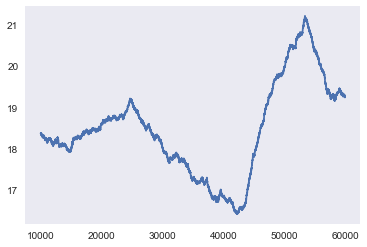

In [43]:
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

**Spolier** to save your time: if you get such a graph of the loss function, it's OK. 

<img src='../../img/assignment8_loss.png' width=40%>

In [17]:
last_10k_train_loss = np.mean(metrics['loss'][-20000:-10000]) 
print('Mean of the loss function on the last 10k TRAIN samples: {:.2f}'.format(last_10k_train_loss))

Mean of the loss function on the last 10k TRAIN samples: 19.27


**<font color="red">Question 3:</font> What's the average value of the cost function for the last 10000 examples of the training set?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q3__*

**<font color="red">Answer options:</font>**
1. 18.31
2. 19.86
3. 21.74
4. 26.43

**The answer is 19.86**

## 4. Model testing

In the base model, the first 60k rows are used for training, and the remaining ones are used as a test set. As you can see, the value of negative log-likelihood is not very informative, although it allows you to compare different models. In the fourth task, you need to modify the base model so that the `fit_dataframe` method calculate the value of _accuracy_ on the test portion of the dataset for every sample.

The accuracy is defined as following:
- consider that the question has a tag if the predicted probability of the tag is greater than 0.9
- the accuracy of one example is calculated as [Jaccard coefficient](https://en.wikipedia.org/wiki/Jaccard_index) between the set of real tags and tags predicted by the model
  - for example, if the example has real tags ['html', 'jquery'], and according to the model they are ['ios', 'html', 'java'], then the Jaccard coefficient will be |['html', 'jquery'] $\cap$ ['ios', 'html', 'java']| / |['html', 'jquery'] $\cup$ ['ios', 'html', 'java']| = |['html']| / |['jquery', 'ios', 'html', 'java']| = 1/4
- `fit_dataframe` method returns _pd.DataFrame_ with column _Jaccard_ 
- For answer you need to calculate **average (mean)** accuracy on _Jaccard_ column on the test set

<font color="red">Modified class:</font>

In [18]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.4'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            # HERE'S YOUR CODE
            
            z = self._b[tag]
            
            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                # HERE'S YOUR CODE
                
                z += self._w[tag][self._vocab[word]] 
            
            # HERE'S YOUR CODE
            
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            
            # HERE'S YOUR CODE
            
            sample_loss += -y * np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                           -(1 - y) * np.log(1 - np.min([1 - self.tolerance, sigma]))

            if sample_id < self.top_n_train:
                # HERE'S YOUR CODE
                
                dLdw = y - sigma
                
                delta = self.learning_rate * dLdw
                
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= -delta
                self._b[tag] -= -delta
            else:
                if predicted_tags is None:
                    predicted_tags = []
                # HERE'S YOUR CODE
               
                if sigma > self.accuracy_level:
                    predicted_tags.append(tag)
        
        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        if predicted_tags is not None:
            # HERE'S YOUR CODE
            
            Jaccard = len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags))
            
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9):
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        
        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.generate_vocab(df, column_name='question')
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

In [19]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df)

LogRegressor v0.4 | 70000 (100.00%) samples fitted.
Wall time: 2min 15s


In [20]:
metrics.head()

,loss,Jaccard
0,2.4134e-11,nan
1,8.2889,nan
2,5.86224,nan
3,5.80809,nan
4,1.75791,nan


In [21]:
metrics.tail()

,loss,Jaccard
69995,3.04177,0.5
69996,110.315,0
69997,29.9103,0.5
69998,36.8414,0
69999,12.2607,0


In [23]:
# HERE'S YOUR CODE

accuracy = metrics.loc[metrics['Jaccard'].notnull(), 'Jaccard'].mean()

print('Mean Jaccard accuracy: {:.2f}'.format(accuracy))

Mean Jaccard accuracy: 0.61


**<font color="red">Question 4:</font> What mean Jaccard accuracy did you get for the test set?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q4__*

**<font color="red">Answer options:</font>**
1. 0.31
2. 0.41
3. 0.51
4. 0.61

**The answer is 0.61**

## 5. $L_2$-regularization

In the fifth task, you need to add $ L_2 $-regularization to the `LogRegressor` class. In the `fit_sample` method, the` l2_reg = 0.01` parameter with the default value should appear. Taking into account regularization, the new cost function takes the form:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^d w_{ki}^2
\end{array}$$

We have already derived the gradient of the first term of the sum, and for the second one it looks like:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

If we make an explicit update of all weights on each example, then the process will be very slow, because we have to run through every word of the dictionary at each iteration. At the expense of the theoretical accuracy, we use a dirty trick: we will regularize only those words that are present in the current sentence. Do not forget that the bias term is not regularized. `sample_loss` should also remain unchanged.

<font color="red">Modified class:</font>

In [24]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.5'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            # HERE'S YOUR CODE
            
            z = self._b[tag] 
            
            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                # HERE'S YOUR CODE
             
                z += self._w[tag][self._vocab[word]] 
            
            # HERE'S YOUR CODE
            
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            
            # HERE'S YOUR CODE
            
            sample_loss += -y * np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                           -(1 - y) * np.log(1 - np.min([1 - self.tolerance, sigma]))

            if sample_id < self.top_n_train:
                # HERE'S YOUR CODE
                
                dLdw = y - sigma
                
                delta = self.learning_rate*dLdw
                
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= (- delta
                                                        + self.learning_rate * self.lambda_*
                                                        self._w[tag][self._vocab[word]])
                self._b[tag] -= -delta
            else:
                if predicted_tags is None:
                    predicted_tags = []
                # HERE'S YOUR CODE
                # if sigma... :
                #     predicted_tags...
                if sigma > self.accuracy_level:
                    predicted_tags.append(tag)
        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        if predicted_tags is not None:
            # HERE'S YOUR CODE
            
            Jaccard = len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags))
            
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9,
                      lambda_=0.01):
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        self.lambda_ = lambda_

        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.generate_vocab(df, column_name='question')
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

In [25]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df)

LogRegressor v0.5 | 70000 (100.00%) samples fitted.
Wall time: 3min 18s


0.52


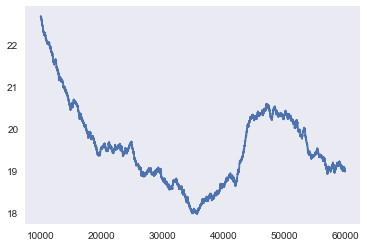

In [26]:
# HERE'S YOUR CODE

accuracy = metrics.loc[metrics['Jaccard'].notnull(), 'Jaccard'].mean()
print('{:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

**<font color="red">Question 5:</font> What's the average value of Jaccard accuracy in case of $L_2$-regularization?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q5__*

**<font color="red">Answer options:</font>**
1. 0.32
2. 0.38
3. 0.48
4. 0.52 

**The answer is 0.48**

## 6. ElasticNet regularization, derivation
In addition to $ L_2 $ regularization, $ L_1 $ regularization is often used.

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \lambda \sum_{k=1}^K\sum_{i=1}^d \left|w_{ki}\right|
\end{array}$$

If we linearly combine $ L_1 $ and $ L_2 $ regularization, then the resulting regularization type is called **ElasticNet**:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \lambda R\left(W\right) \\
&=& -\mathcal{L} + \lambda \left(\gamma \sum_{k=1}^K\sum_{i=1}^d w_{ki}^2 + \left(1 - \gamma\right) \sum_{k=1}^K\sum_{i=1}^d \left|w_{ki}\right| \right)
\end{array}$$
- where $\gamma \in \left[0, 1\right]$

**<font color="red">Question 6:</font> What's the correct formula for the gradient of the ElasticNet regularization term?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q6__*

**<font color="red">Answer options:</font>**
1. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(\gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
2. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) w_{ki}\right)$ 
3. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
4. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma \left|w_{ki}\right| + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$

**<font color="red">Derivation:</font>**

$$\Large \begin{array}{rcl}
\frac{\partial \lambda R\left(W\right)}{\partial w_{ki}} &=& \frac{\partial}{\partial w_{ki}} \lambda \left(\gamma \sum_{k=1}^K\sum_{i=1}^d w_{ki}^2 + \left(1 - \gamma\right) \sum_{k=1}^K\sum_{i=1}^d \left|w_{ki}\right| \right) \\
&=& \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)
\end{array}$$

**The answer is the 3rd one**

## 7. ElasticNet regularization, implementation

In the seventh task you are supposed to change the class `LogRegressor` so that the` fit_dataframe` method takes two parameters with default values `l2_reg = 0.001` and `l1_reg = 0.1`. Do one pass through the dataset with ElasticNet regularization and default parameter values and answer the question.

<font color="red">Modified class:</font>

In [27]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.7'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            # HERE'S YOUR CODE
            
            z = self._b[tag] 
            
            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                # HERE'S YOUR CODE
             
                z += self._w[tag][self._vocab[word]] 
            
            # HERE'S YOUR CODE
            
            sigma = 1 / (1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            
            # HERE'S YOUR CODE
            
            sample_loss += -y * np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                           -(1 - y) * np.log(1 - np.min([1 - self.tolerance, sigma]))

            if sample_id < self.top_n_train:
                # HERE'S YOUR CODE
            
                dLdw = y - sigma
                
                delta = self.learning_rate*dLdw
                
                for word in question:                        
                    word_weight = self._w[tag][self._vocab[word]]
                    self._w[tag][self._vocab[word]] -= (- delta
                                                        + self.loss_factor * word_weight
                                                        + self.loss_factor2 * np.sign(word_weight))
                self._b[tag] -= -delta
            
            else:
                if predicted_tags is None:
                    predicted_tags = []
                # HERE'S YOUR CODE
                
                if sigma > self.accuracy_level:
                    predicted_tags.append(tag)
        
        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        
        if predicted_tags is not None:
            # HERE'S YOUR CODE
            
            Jaccard = len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags))
            
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9,
                      lambda_=0.001,
                      gamma=0.1):
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        self.lambda_ = lambda_
        self.gamma = gamma
        self.loss_factor = 2 * self.learning_rate * self.lambda_ * self.gamma
        self.loss_factor2 = self.learning_rate * self.lambda_ * (1 - self.gamma)

        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.generate_vocab(df, column_name='question')
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

In [28]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df)

LogRegressor v0.7 | 70000 (100.00%) samples fitted.
Wall time: 9min 20s


Mean Jaccard accuracy: 0.60


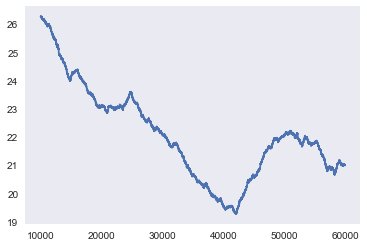

In [29]:
# HERE'S YOUR CODE

accuracy = metrics.loc[metrics['Jaccard'].notnull(), 'Jaccard'].mean()
print('Mean Jaccard accuracy: {:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

**<font color="red">Question 7:</font> What's the average value of Jaccard accuracy in case of ElasticNet regularization?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q7__*

**<font color="red">Answer options:</font>**
1. 0.51
2. 0.61
3. 0.71
4. 0.81

**The answer is 0.61**

## 8. The most important words for a tag

The beauty of linear models is that they are somewhat interpretable. You are supposed to calculate which words contribute the most to the probability of each of the tags. And then answer the question.

In [30]:
model._vocab_inv = dict([(v, k) for (k, v) in model._vocab.items()])
top = 5
for tag in model._tags:
    # HERE'S YOUR CODE
    
    top5_words = [
        model._vocab_inv[k] for (k, v) in sorted(model._w[tag].items(), 
                                                 key=lambda t: t[1], 
                                                 reverse=True)[:5]
    ]
    print(tag, ':', ', '.join(top5_words))   

ios : ios, nsstring, nil, xcode, iphone
html : html, some, span, href, quot
c++ : c++, cout, std, _defaultimage, const
php : php, x5c, echo, 125, _post
c# : nbsp, binding, writeline, 00, asp
android : android, 08, imgsrv, 29297, 0x0
javascript : javascript, 125, angular, span, getelementbyid
java : println, java, spring, quot, servlet
jquery : jquery, ready, ajax, val, option
python : python, def, py, np, print


For many tags, the presence of the tag itself in the sentence is an important signal, and for many, the tag itself is the strongest signal, which is not surprising. 

**<font color="red">Question 8:</font> For which of the tags the tag name itself is not included in the top 5 most important words?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q8__*

**<font color="red">Answer options:</font>**
1. android
2. javascript
3. jquery
4. c#

**The answer is c#.**

## 9. Reducing the size of the dictionary

Now the number of words in the dictionary is too big. If it was a sample of 10 million questions from the StackOverflow website, then the dictionary size would've been ~ 10 million as well. You can regularize the model not only mathematically, but also simply limiting the size of the dictionary. You are supposed to make the following changes in the class `LogRegressor`:
- add `self._word_stats = defaultdict(int)` to `__init__` to calculate word frequencies
- add one more argument to the `fit_dataframe` method with the default value `freeze_vocab = False`
- when `freeze_vocab = False` allow to add words to the dictionary and word_stats
- when `freeze_vocab = True` ignore words not from the dictionary and don't update word_stats
- add the class method `filter_vocab (n = 10000)`, which will leave only top-n most popular words in the dictionary

For first `fit_dataframe` call use `learning_rate=0.2`.

<font color="red">Modified class:</font>

In [31]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.9'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
        self._word_stats = defaultdict(int)

    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)

    def filter_vocab(self, top_n=10000):
        keep_words = set([wid for (wid, wn) in sorted(self._word_stats.items(), 
                                                      key=lambda t: t[1], reverse=True)[:top_n]])
        self._vocab = dict([(k, v) for (k, v) in self._vocab.items() if v in keep_words])
        for tag in self._tags:
            self._w[tag] = dict([(k, v) for (k, v) in self._w[tag].items() if k in keep_words])

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            # HERE'S YOUR CODE
            
            z = self._b[tag] 
            
            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                if is_word_unknown:
                    continue
                if not self.freeze_vocab:
                    self._word_stats[self._vocab[word]] += 1
                # HERE'S YOUR CODE
              
                z += self._w[tag][self._vocab[word]] 
            
            # HERE'S YOUR CODE
            
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            
            # HERE'S YOUR CODE
            
            sample_loss += -y*np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                           -(1 - y)*np.log(1 - np.min([1 - self.tolerance, sigma]))

            if sample_id < self.top_n_train:
                # HERE'S YOUR CODE
                
                dLdw = y - sigma
                
                delta = self.learning_rate*dLdw
                
                for word in question:
                    if word not in self._vocab:
                        continue                        
                    word_weight = self._w[tag][self._vocab[word]]
                    self._w[tag][self._vocab[word]] -= (- delta
                                                        + self.loss_factor * word_weight
                                                        + self.loss_factor2 * np.sign(word_weight))
                self._b[tag] -= -delta
            else:
                if predicted_tags is None:
                    predicted_tags = []
                # HERE'S YOUR CODE
               
                if sigma > self.accuracy_level:
                    predicted_tags.append(tag)
        
        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        
        if predicted_tags is not None:
            # HERE'S YOUR CODE
         
            Jaccard = len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags))
            
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9,
                      lambda_=0.01,
                      gamma=0.1,
                      freeze_vocab=False):
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        self.lambda_ = lambda_
        self.gamma = gamma
        self.loss_factor = 2 * self.learning_rate * self.lambda_ * self.gamma
        self.loss_factor2 = self.learning_rate * self.lambda_ * (1 - self.gamma)

        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.freeze_vocab = freeze_vocab
        if not self.freeze_vocab:
            self.generate_vocab(df, column_name='question')

        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

LogRegressor v0.9 | 70000 (100.00%) samples fitted.
Mean Jaccard accuracy: 0.54
Wall time: 11min 8s


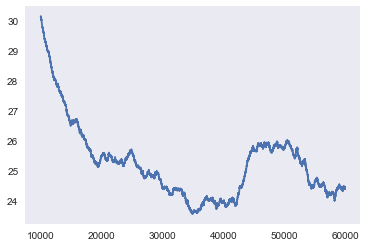

In [32]:
%%time
model = LogRegressor(tags=top_tags)
# HERE'S YOUR CODE

metrics = model.fit_dataframe(df, learning_rate=0.2)

# HERE'S YOUR CODE

accuracy = metrics.loc[metrics['Jaccard'].notnull(), 'Jaccard'].mean()

print('Mean Jaccard accuracy: {:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

We leave only 10 000 words.

In [33]:
model.filter_vocab(top_n=10000)

Do one more iteration through the dataset, reducing learning rate 20 times and L2-regularization 5 times with freezed vocab:

LogRegressor v0.9 | 70000 (100.00%) samples fitted.
Mean Jaccard accuracy: 0.67
Wall time: 8min 40s


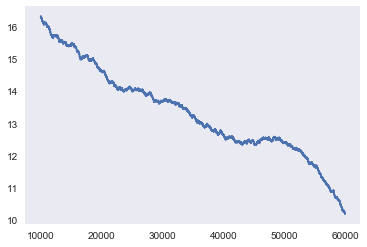

In [34]:
%%time
# HERE'S YOUR CODE

metrics = model.fit_dataframe(df, learning_rate=0.01, lambda_=0.002, freeze_vocab=True)

# HERE'S YOUR CODE

accuracy = metrics.loc[metrics['Jaccard'].notnull(), 'Jaccard'].mean()

print('Mean Jaccard accuracy: {:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

**<font color="red">Question 9:</font> What's the average value of Jaccard accuracy in case of reducing the dictionary size?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q9__*

**<font color="red">Answer options:</font>**
1. 0.66
2. 0.69
3. 0.72 
4. 0.75

**The answer is 0.66**

## 10. Predicting tags for new questions

At the end of this assignment, you are supposed to implement the method `predict_proba`, which takes a model and a string containing the question and returns a list of predicted question tags with their probabilities.

In [35]:
def predict_proba(model, sentence):
    p = {}
    # HERE'S YOUR CODE
    
    sentence = sentence.split(' ')
    
    for tag in model._tags:
        z = model._b[tag]
        for word in sentence:
            if word not in model._vocab:
                continue
            z += model._w[tag][model._vocab[word]]
        
        sigma = 1 / (1 + np.exp(-z)) if z >= 0 else 1 - 1 / (1 + np.exp(z))
        
        p[tag] = sigma
    
    return p

In [36]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")

Preprocessing of the question (sentence) will only include converting it to lower case and deleting commas.

In [37]:
pred = predict_proba(model, sentence.lower().replace(',', ''))

In [38]:
tag_preds = sorted(pred.items(), key=lambda t: t[1], reverse=True)

In [39]:
list(filter(lambda t: t[1] > 0.9, tag_preds))

[('ios', 0.9999999999698286)]

**<font color="red">Question 10:</font> Which tag or tags are associated with this question if the acceptance threshold is $ 0.9 $?**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a8_q10__*

**<font color="red">Answer options:</font>**
1. ios
2. android
3. c#, c++
4. ios, php

**The answer is 1.ios.**

PS: in the original question the following four tags are put: java, android, objective-c, ios.